# Man vs Woman
Use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

## Loading the packages

In [25]:
import numpy as np
import os
import scipy.io.wavfile as wav

from matplotlib import pyplot as pl
from python_speech_features import mfcc

%matplotlib inline

## The datasets

In [26]:
PATH = './vowels/'

In [27]:
def create_dataset(categories):

    dataset = []

    # Read all files
    for i, c in categories:
        for file in os.listdir(PATH):
            if file.startswith(c):
                #print(file + " " + str(i))
                
                # Read the wav file and compute the MFCC coefficients
                sample_rate, X = wav.read(os.path.join(PATH, file))
                ceps = mfcc(X, samplerate=sample_rate, nfft=1024)

                # Compute the mean and the standard deviation
                mean = np.mean(ceps, axis=0)

                dataset.append(np.append(mean, i))
      
    # Normalize window temporal (mfcc) [-1,1]
    normalized = []
    data = np.array(dataset).transpose()
    for i in range(0, len(data)-1):
        normalized.append(2*(data[i] - np.max(data[i]))/-np.ptp(data[i])-1)

    normalized.append(data[len(data) - 1])
                
    return np.array(normalized).transpose()

## The MLP
Import the code of the backpropagation with momentum algorithm

In [28]:
import mlp_backprop_momentum as mlp

## Cross-validation
Import the code of the cross-valdidation test

In [29]:
import k_fold_cross_validation as cv

## Dataset

In [33]:
CATEGORIES = [(-1, 'nam'),(-1, 'sam'), (1, 'nk'), (1, 'sk')]
dataset = create_dataset(CATEGORIES)

count1 = 0
for x in dataset[:,13:14]:
    if x == 1:
        count1 = count1 + 1
        
count2 = 0
for x in dataset[:,13:14]:
    if x == -1:
        count2 = count2 + 1

print("Class 1: " + str(count))
print("Class -1: " + str(count2))

Class 1: 216
Class -1: 72


## Exploring the number of epochs

In [31]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.8

In [34]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


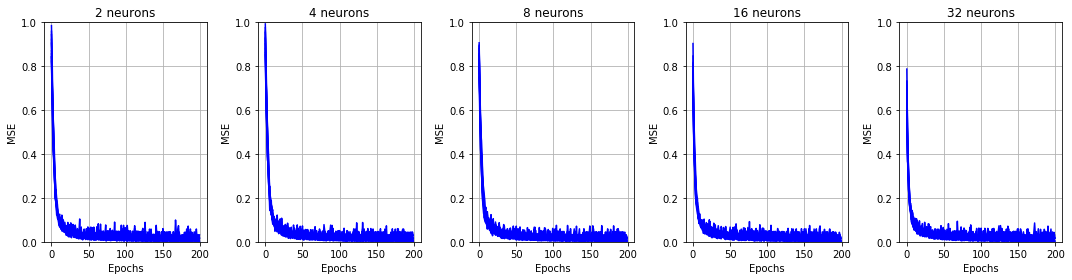

In [35]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

## Exploring the number of hidden neurons

In [39]:
EPOCHS = 100
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [40]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


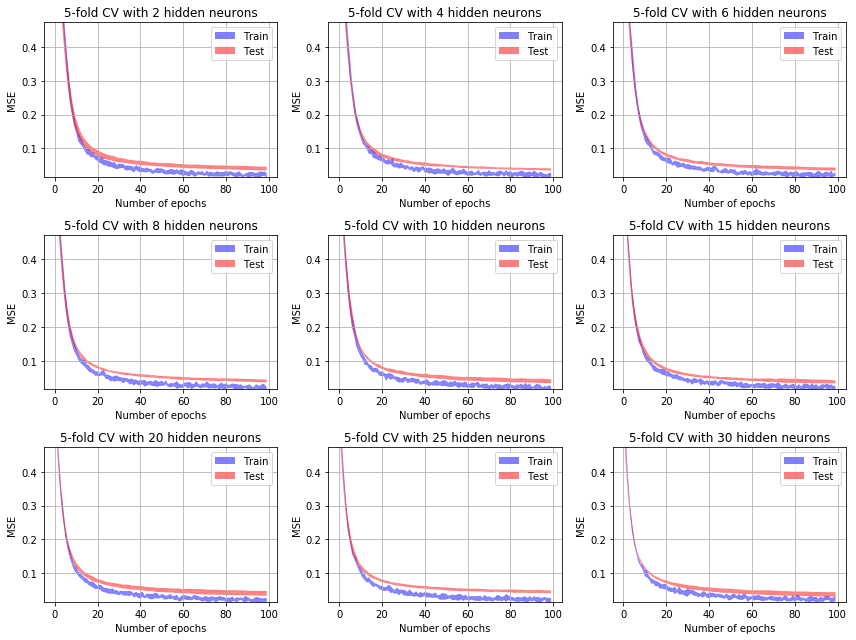

In [41]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

## The final model

In [281]:
nn = mlp.MLP([13,2,1], 'tanh')

In [42]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=50,
                                                          threshold=0.0)

a = nn.compute_output(np.array(dataset)[:,0:13])
a[a >= 0] = 1
a[a < 0] = -1

import pandas as pd # pd is a convention too

colnames = np.array([
    'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 
    'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
    'mfcc_13', 'class', 'prediction'
])

output = (np.append(dataset.transpose(), np.array(a).transpose(), axis=0)).transpose()

df = pd.DataFrame(data=output, columns=colnames)


In [43]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.029842229673917725
MSE test:  0.03966151880911232
Confusion matrix:
[[215.   1.]
 [  1.  71.]]


In [44]:
import matplotlib.cm as cm

def plot_confusion_matrix(confmat, labels_names, ax=None):
    if ax is None:
        ax = pl.subplot(111)
    cmim = ax.matshow(confmat, interpolation='nearest', cmap=cm.jet)

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.annotate(str(confmat[i, j]), xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=8)
    ax.set_xticks(np.arange(confmat.shape[0]))
    ax.set_xticklabels([labels_names[l] for l in range(confmat.shape[0])], rotation='vertical')
    ax.set_yticks(np.arange(confmat.shape[1]))
    _ = ax.set_yticklabels([labels_names[l] for l in range(confmat.shape[1])])
    ax.set_xlabel('predicted label')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('true label')
    pl.colorbar(cmim, shrink=0.7, orientation='horizontal', pad=0.01)

             precision    recall  f1-score   support

       -1.0       1.00      0.99      0.99        72
        1.0       1.00      1.00      1.00       216

avg / total       1.00      1.00      1.00       288



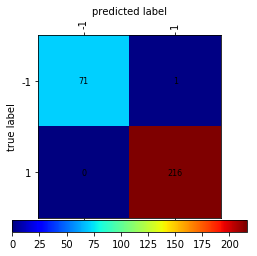

In [45]:
import sklearn.metrics as skmetrics

labels_names=['-1', '1']
C = skmetrics.confusion_matrix(y_true=df['class'], y_pred=df['prediction'])
plot_confusion_matrix(C, labels_names)

print(skmetrics.classification_report(y_true=df['class'], y_pred=df['prediction']))